# Exercise - Regularized polynomial regression

In [1]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np

In the first part of this exercise, you will implement regularized linear regression to
predict the amout of water flowing out of a dam as a function of the change of water
level in a reservoir.

The provided dataset consists of one feature (change in water level) and one label
(amout of water flowing out of the dam) and it is divided into three parts corresponding
to the training, validation and test sets.

In [2]:
# Change the path if needed
data = loadmat('data/poly_regression/ex5data1.mat')

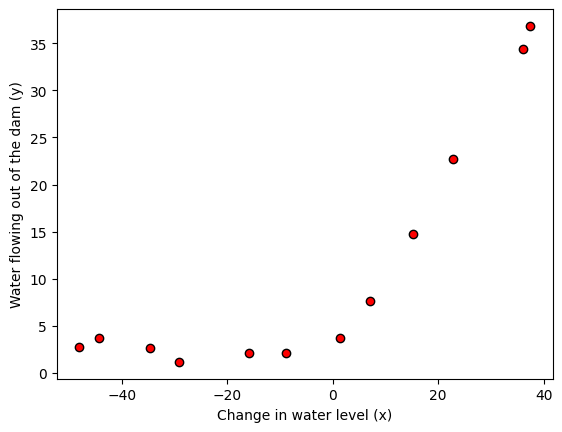

In [3]:
# Extract train, test, validation data
X, y = data['X'], data['y'][:, 0]
Xtest, ytest = data['Xtest'], data['ytest'][:, 0]
Xval, yval = data['Xval'], data['yval'][:, 0]

y = y.reshape(-1,1)
yval = yval.reshape(-1,1)
ytest = ytest.reshape(-1,1)

# Number of samples
N = y.size

# Plot training data
plt.plot(X, y, 'ro', ms=6, mec='k', mew=1)
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)');
plt.show()

In [4]:
# adding column of ones
X_ = np.hstack((np.ones((X.shape[0],1)), X))
Xval_ = np.hstack((np.ones((Xval.shape[0],1)), Xval))

In [5]:
# Auxiliary function for dataset normalization
def featureNormalize(X):
    mu = np.mean(X, axis=0)
    X_norm = X - mu

    sigma = np.std(X_norm, axis=0, ddof=1)
    X_norm /= sigma
    return X_norm, mu, sigma

1. Implement the `RegularizedLinearRegression` class by extending the `LinearRegression`
   class seen in the previous exercises. The cost function should include a L2
   regularization term and the appropriate gradient of it should be computed for
   gradient descent.

In [6]:
class RegularizedLinearRegression:
    def __init__(self, num_features=1):
        # min and max of the interval where random values for the weights should be sampled
        b = -1.
        a = 1.
        # weights vector includes slopes and bias
        self.w = (b - a) * np.random.random_sample((num_features + 1,1)) + a

    # Here lam is the regularization factor
    def fit(self, X, y, learning_rate, epochs, lam=0.):
        self.loss_history = []

        N = X.shape[0]
        
        for _ in range(epochs):
            dlossdw = (2/N)*X.T @ (self.predict(X)-y)
            dlossdw[1:] += 2*lam/N*self.w[1:]
            self.w -= learning_rate*dlossdw
            training_prediction = self.predict(X)
            loss = self.loss(training_prediction, y, lam)
            self.loss_history.append(loss)
    
    def loss(self, prediction, y, lam):
        N = len(prediction)
        return np.linalg.norm(prediction - y)**2/N + (lam/N)*np.sum(self.w[1:]**2)

    def predict(self, X):
        return X @ self.w

2. Train the model with zero regularization (standard linear regression) and plot the
   best fit line along with the training data. Do not normalize the dataset.

In [7]:
lr = RegularizedLinearRegression()
lr.fit(X_, y, 0.001, 10000)

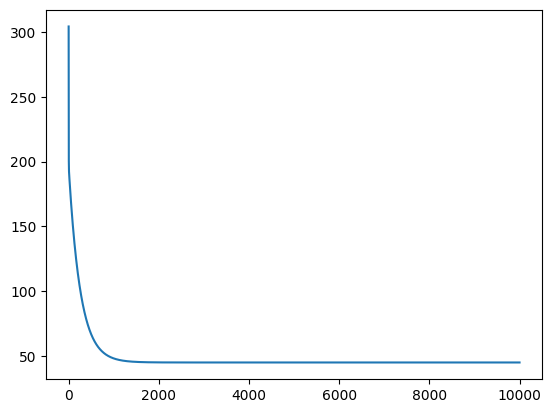

In [8]:
plt.plot(lr.loss_history)
plt.show()

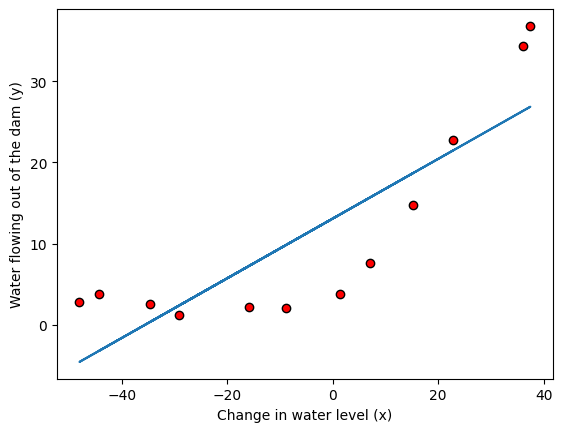

In [9]:
plt.plot(X, y, 'ro', ms=6, mec='k', mew=1)
plt.plot(X, lr.predict(X_))
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)');
plt.show()

3. Compute the errors on the training and the validation datasets.

In [10]:
print("MSE on training set = ", lr.loss(lr.predict(X_), y, 0.))
print("MSE on validation set = ", lr.loss(lr.predict(Xval_), yval, 0.))

MSE on training set =  44.747812990217824
MSE on validation set =  58.867636373897


## Adding polynomial features

The problem with our linear model was that it was too simple for the data, and resulted in underfitting (high bias). In this part of the exercise, you will address this problem by adding more features. For polynomial regression, our hypothesis has the form:
    $$
    \begin{align}
    h_\theta(x)  &= \theta_0 + \theta_1 \times (\text{waterLevel}) + \theta_2 \times
    (\text{waterLevel})^2 + \cdots + \theta_p \times (\text{waterLevel})^p \\   
    & = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \cdots + \theta_p x_p
    \end{align}
    $$

Notice that by defining $x_1 = (\text{waterLevel})$, $x_2 = (\text{waterLevel})^2$ ,
$\cdots$, $x_p = (\text{waterLevel})^p$, we obtain a linear regression model where the
features are the various powers of the original value (waterLevel).

Now, you will add more features using the higher powers of the existing feature $x$ in
the dataset. 

1. Complete the code in the function `polyFeatures` in the next cell. The function should map the original training set $X$
of size $N \times 1$ into its higher powers. Specifically, when a training set $X$ of size $N \times 1$ is passed into the function, the function should return a $N \times p$ matrix `X_poly`, where column 1 holds the original values of X, column 2 holds the values of $X^2$, column 3 holds the values of $X^3$, and so on. Note that you don’t have to account for the zero-eth power in this function.

In [11]:
def polyFeatures(X, p):
    """
    Maps X (1D vector) into the p-th power.
    
    Parameters
    ----------
    X : array_like
        A data vector of size m, where m is the number of examples.
    
    p : int
        The polynomial power to map the features. 
    
    Returns 
    -------
    X_poly : array_like
        A matrix of shape (m x p) where p is the polynomial 
        power and m is the number of examples. That is:
    
        X_poly[i, :] = [X[i], X[i]**2, X[i]**3 ...  X[i]**p]
    """
    X_poly = np.hstack([X**i for i in range(1, p + 1)])
    return X_poly

In [12]:
# Build the polynomial features up to 8-th degree
p = 8

# Map X onto Polynomial Features and Normalize
X_poly = polyFeatures(X, p)
X_poly, mu, sigma = featureNormalize(X_poly)
X_poly = np.concatenate([np.ones((N, 1)), X_poly], axis=1)

# Map X_poly_test and normalize (using mu and sigma)
X_poly_test = polyFeatures(Xtest, p)
X_poly_test -= mu
X_poly_test /= sigma
X_poly_test = np.concatenate([np.ones((ytest.size, 1)), X_poly_test], axis=1)

# Map X_poly_val and normalize (using mu and sigma)
X_poly_val = polyFeatures(Xval, p)
X_poly_val -= mu
X_poly_val /= sigma
X_poly_val = np.concatenate([np.ones((yval.size, 1)), X_poly_val], axis=1)

2. Train the model using the polynomial features. Choose 0.01 for the learning rate and
   10000 for the epochs. Plot the history of the loss. 

In [13]:
lr = RegularizedLinearRegression(p)
lr.fit(X_poly, y, 0.01, 10000)

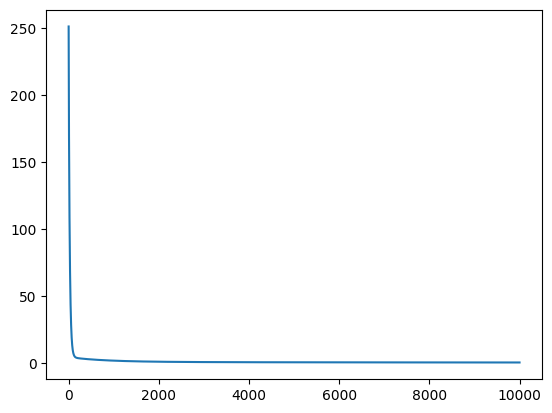

In [14]:
plt.plot(lr.loss_history)
plt.show()

3. Execute the following cell to plot the training set and the fitted polynomial model.

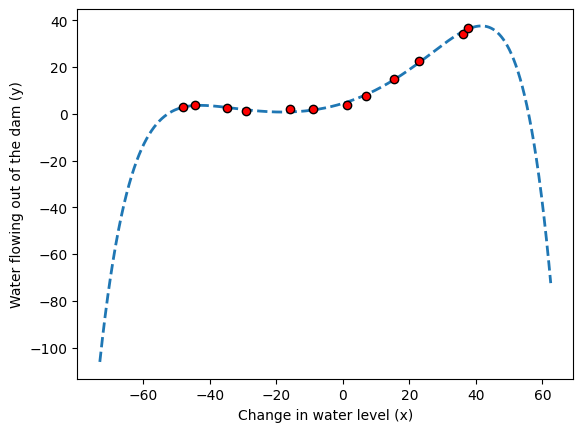

In [15]:
# We plot a range slightly bigger than the min and max values to get
# an idea of how the fit will vary outside the range of the data points
x = np.arange(np.min(X) - 25, np.max(X) + 25, 0.05).reshape(-1, 1)

# Map the X values
x_poly = polyFeatures(x, p)
x_poly -= mu
x_poly /= sigma

# Add ones
x_poly = np.concatenate([np.ones((x.shape[0], 1)), x_poly], axis=1)
plt.plot(x, lr.predict(x_poly), '--', lw=2)

plt.plot(X, y, 'ro', ms=6, mec='k', mew=1)

plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)');
plt.show()

4. Compute the MSE on the training and the validation datasets.

In [16]:
print("MSE on training set = ", lr.loss(lr.predict(X_poly), y, 0.))
print("MSE on validation set = ", lr.loss(lr.predict(X_poly_val), yval, 0.))

MSE on training set =  0.5739298751294112
MSE on validation set =  29.269302800095915


5. Find the value of the learning rate in the interval $[0,10]$ that minimizes the
   validation MSE. Plot the training and validation MSEs as a function of the learning rate. 

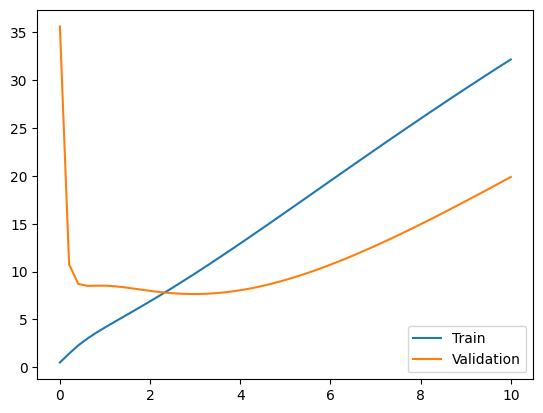

In [17]:
train_MSE = []
val_MSE = []
lambdas = np.linspace(0., 10., 50)
for lam in lambdas:
    lr.fit(X_poly, y, 0.01, 10000, lam)
    train_MSE.append(lr.loss(lr.predict(X_poly), y, 0.))
    val_MSE.append(lr.loss(lr.predict(X_poly_val), yval, 0.))

plt.plot(lambdas, train_MSE, label="Train")
plt.plot(lambdas, val_MSE, label="Validation")
plt.legend()
plt.show()

6. Use the optimal value of the learning rate found in the previous step to re-train the
   model. Plot the model predictions and the training data.

In [18]:
best_lambda = lambdas[np.argmin(val_MSE)].item()
print(best_lambda)

3.0612244897959187


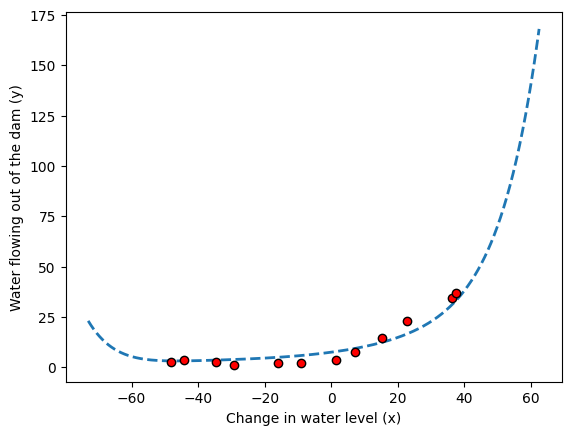

In [19]:
lr.fit(X_poly, y, 0.01, 10000, best_lambda)

plt.plot(x, lr.predict(x_poly), '--', lw=2)

plt.plot(X, y, 'ro', ms=6, mec='k', mew=1)

plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)');
plt.show()

7. Evaluate the MSEs on the training, validation and test sets for the re-trained model.

In [20]:
print("MSE on training set = ", lr.loss(lr.predict(X_poly), y, 0.))
print("MSE on validation set = ", lr.loss(lr.predict(X_poly_val), yval, 0.))
print("MSE on test set = ", lr.loss(lr.predict(X_poly_test), ytest, 0.))

MSE on training set =  9.98910880372505
MSE on validation set =  7.648502409960909
MSE on test set =  7.869677990737559
